<h1>Rag From Scratch: Indexing

<h2>Environment

In [1]:
from dotenv import load_dotenv
import os

load_dotenv(".env")
openai_api_key = os.getenv("OPENAI_API_KEY")
langsmith_api_key = os.getenv("LANGCHAIN_API_KEY")

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_PROJECT'] ="RAG_Multi_Query"
os.environ['LANGCHAIN_API_KEY'] = langsmith_api_key
os.environ['OPENAI_API_KEY'] = openai_api_key

<h2>Part 12: Multi-representation Indexing

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [ ]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(model="gpt-3.5-turbo",max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [ ]:
summaries

In [ ]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [ ]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

In [ ]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

<h2>Part 13: RAPTOR

Flow:

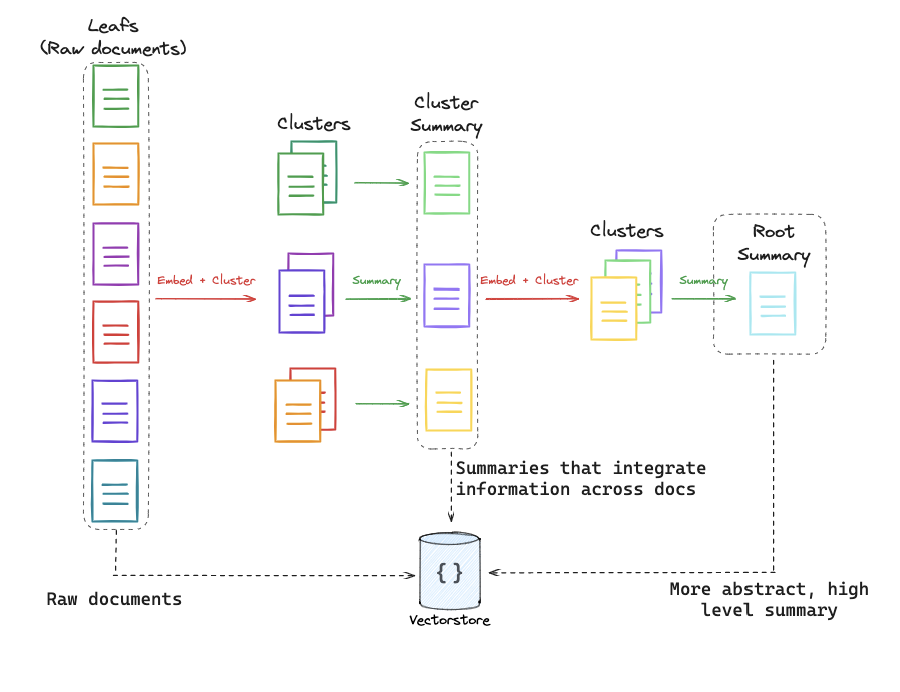

Deep dive video:

https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

https://arxiv.org/pdf/2401.18059.pdf

Full code:

https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

<h2>Part 14: ColBERT

RAGatouille makes it as simple to use ColBERT.

ColBERT generates a contextually influenced vector for each token in the passages.

ColBERT similarly generates vectors for each token in the query.

Then, the score of each document is the sum of the maximum similarity of each query embedding to any of the document embeddings:

In [ ]:
#pip install -U ragatouille

In [2]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

c:\Users\Linh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Linh\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Linh\.cache\huggingface\hub\models--colbert-ir--colbertv2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an admi

[Feb 25, 15:44:51] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


c:\Users\Linh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\cpp_extension.py:414: UserWarning: Error checking compiler version for cl: [WinError 2] Das System kann die angegebene Datei nicht finden
  warnings.warn(f'Error checking compiler version for {compiler}: {error}')


CalledProcessError: Command '['where', 'cl']' returned non-zero exit status 1.

In [3]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [4]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

NameError: name 'RAG' is not defined

In [ ]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")